In [1]:
from __future__ import annotations
import polars as pl
import seaborn as sns
import tqdm
from databento_dbn import FIXED_PRICE_SCALE, UNDEF_PRICE
# plot price of each over time
import plotly.graph_objs as go
import plotly.offline as pyo
from helpers import * 
import pandas as pd
import numpy as np
import datetime as dt  # For plotting x-axis as dates
import matplotlib.pyplot as plt
import statsmodels.api as sm

# from external.arbitragelab.trading import BasicCopulaTradingRule
# import external.arbitragelab.copula_approach.copula_calculation as ccalc
# from external.arbitragelab.copula_approach.archimedean import (Gumbel, Clayton, Frank, Joe, N13, N14)
# from external.arbitragelab.copula_approach.elliptical import (StudentCopula, GaussianCopula)

In [2]:
data = pl.read_parquet("/Users/danny/trading/databento/mbp.parquet")
data = data.filter((pl.col("symbol") == "GOOGL") | (pl.col("symbol") == "GOOG"))
data = data.filter(pl.col("price") != UNDEF_PRICE)
data = data.with_columns(pl.col("ts_event") - pl.col("ts_event").min())
data = data[:5_000_000]
data = data.filter(pl.col("price") < 200370000000.0)
data.shape

(4999993, 75)

851160
Window 5 Pearson correlation: 0.0002452953754198234
Window 10 Pearson correlation: 0.0012246222993293754
Window 15 Pearson correlation: -0.0003981258315248891
Window 20 Pearson correlation: -0.0021719069448871654
Window 25 Pearson correlation: -0.0012335859340798475
Window 30 Pearson correlation: -9.424055250143576e-05
Window 35 Pearson correlation: -6.332097930983331e-05
Window 40 Pearson correlation: -0.00019546499518780563
Window 45 Pearson correlation: 0.0005950512410812365
Window 50 Pearson correlation: 0.0025687381527962822
Window 55 Pearson correlation: 0.0051206064458215695
Window 60 Pearson correlation: 0.007333167458341025
Window 65 Pearson correlation: 0.008658146001891884
Window 70 Pearson correlation: 0.008956890056821551
Window 75 Pearson correlation: 0.008677741116612682
Window 80 Pearson correlation: 0.008073862233836557
Window 85 Pearson correlation: 0.007224086446447177
Window 90 Pearson correlation: 0.0061674933296815265
Window 95 Pearson correlation: 0.004914

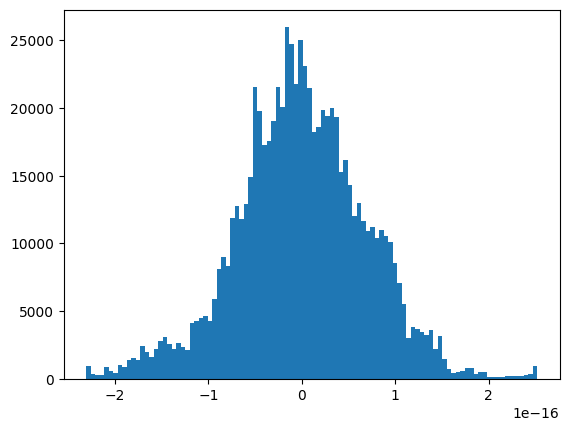

In [6]:

def sliding_mean(val, window_size):
    return np.convolve(val, np.ones(window_size)/window_size, mode='valid')


def copula_pairs(data: pl.DataFrame, symbols: list[str]):
    traces = []
    vals = []
    for symbol in symbols: 
        symbol_data = data.filter(pl.col("symbol") == symbol)
        symbol_data = symbol_data.with_columns(pl.col("ts_event").dt.total_milliseconds())
        symbol_data = symbol_data.group_by("ts_event").agg(pl.col("price").mean())
        symbol_data = symbol_data.with_columns((pl.col("price") / pl.col("price").shift(1)).log())
        symbol_data = symbol_data.with_columns(pl.col("price") / FIXED_PRICE_SCALE)
        merged = symbol_data.to_pandas()
        vec = merged["price"].values
        vals.append(vec)

    # Get a rolling mean over 60

    length = min([len(val) for val in vals])
    vals = [val[2:length] for val in vals]

    # print(f"Distance correlation: {distance_correlation(vals[0], vals[1])}")


    val1 = vals[0]
    val2 = vals[1]
    val1_mean = []
    val2_mean = []
    print(len(val1))
    window_size = 5
    for window_size in range(5, 1000, 5):
        val1 = sliding_mean(val1, window_size)
        val2 = sliding_mean(val2, window_size)
        print(f"Window {window_size} Pearson correlation: {np.corrcoef(val1, val2)[0, 1]}")

    # print the mean difference, and std deviation
    print(np.mean(val1 - val2))
    print(np.std(val1 - val2))
    plt.hist(val1 - val2, bins=100)

copula_pairs(data,["GOOGL", "GOOG"])

In [6]:

def plot_price(data: pl.DataFrame, symbols: list[str]):
    traces = []
    vals = []
    for symbol in symbols: 
        symbol_data = data.filter(pl.col("symbol") == symbol)
        symbol_data = symbol_data.with_columns(pl.col("ts_event").dt.total_seconds())
        symbol_data = symbol_data.group_by("ts_event").agg(pl.col("price").mean())
        symbol_data = symbol_data.with_columns((pl.col("price") / pl.col("price").shift(1)).log())
        symbol_data = symbol_data.with_columns(pl.col("price") / FIXED_PRICE_SCALE)
        merged = symbol_data.to_pandas()
        vec = merged["price"].values
        vals.append(vec)

        trace = go.Scatter(
            x=merged.index,
            y=merged["price"],
            mode='lines',
            name=symbol
        )
        traces.append(trace)

    # Cast to fp16
    # Drop na 
    # vals = [val[~np.isnan(val)] for val in vals]
    length = min([len(val) for val in vals])
    vals = [val[2:length] for val in vals]
    # vals = [np.array(val, dtype=np.float16) for val in vals]
    print(distance_correlation(vals[0], vals[1]))
    print(np.corrcoef(vals[0], vals[1])[0, 1])

    layout = go.Layout(
        title='Interactive Plot of Bid and Ask Prices',
        xaxis=dict(title='Time'),
        yaxis=dict(title='Price'),
        hovermode='closest'
    )

    fig = go.Figure(data=traces, layout=layout)
    pyo.iplot(fig)

plot_price(data,["GOOGL", "GOOG"])